In [1]:
!git clone https://github.com/haladaher2024/ML_project.git


Cloning into 'ML_project'...
remote: Enumerating objects: 1782, done.
remote: Counting objects: 100% (1782/1782), done.
remote: Compressing objects: 100% (941/941), done.
remote: Total 1782 (delta 6), reused 1762 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1782/1782), 3.10 MiB | 6.76 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Handling missing labels

In [3]:
import os
from collections import Counter

# Define paths
image_folder = '/content/ML_project/data/images'
label_folder = '/content/ML_project/data/labels'

# Step 1: List files
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))

# Step 2: Extract basenames (without extensions)
image_basenames = {os.path.splitext(f)[0] for f in image_files}
label_basenames = {os.path.splitext(f)[0] for f in label_files}

# Step 3: Detect missing labels
missing_labels = image_basenames - label_basenames
missing_count = len(missing_labels)
total_images = len(image_basenames)
missing_percentage = (missing_count / total_images) * 100

print(f" Total images: {total_images}")
print(f" Missing labels: {missing_count}")
print(f" Missing %: {missing_percentage:.2f}%")

# Step 4: Handle missing labels
if missing_count == 0:
    print(" All images have corresponding labels.")

elif missing_percentage < 5:
    print("Removing unmatched images less than 5% of labels is missing")
    deleted = 0
    for name in missing_labels:
        img_path = os.path.join(image_folder, name + ".jpg")
        if os.path.exists(img_path):
            os.remove(img_path)
            deleted += 1
    print(f" Deleted {deleted} unmatched images.")
else:
    print("More than 5% of images are missing labels. Please review your dataset.")

# Step 5: Final check
final_images = len(os.listdir(image_folder))
final_labels = len(os.listdir(label_folder))
print(f"Final image count: {final_images}")
print(f" Final label count: {final_labels}")


 Total images: 872
 Missing labels: 0
 Missing %: 0.00%
 All images have corresponding labels.
Final image count: 872
 Final label count: 878


# Checking if the Data is balanced

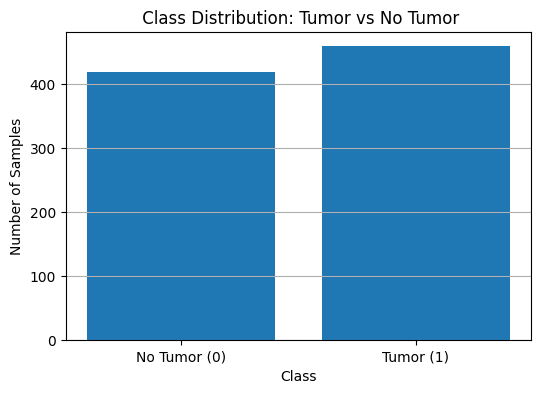


Data is balanced


In [4]:
import matplotlib.pyplot as plt


from collections import Counter
label_folder = '/content/ML_project/data/labels'
label_counts = Counter()

for file in os.listdir(label_folder):
    with open(os.path.join(label_folder, file), 'r') as f:
        line = f.readline().strip()
        if line:
            label = int(line.split()[0])
            label_counts[label] += 1

# Plot
labels = ['No Tumor (0)', 'Tumor (1)']
counts = [label_counts[0], label_counts[1]]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title(" Class Distribution: Tumor vs No Tumor")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.grid(axis='y')
plt.savefig('/content/ML_project/outputs/class_distribution.png')

plt.show()
if(abs(label_counts[0]-label_counts[1])<100):
 print()
 print('Data is balanced')
else:
  print()
  print("Data is imbalanced")

Standardizing the image by resizing to the appropriate size. Tried using normalization as well but didn't give the size we wanted so we stuck to resize.


In [5]:
def standardize_image(image, target_size=(224, 224)):
    # Resize image
    resized = cv2.resize(image, target_size)

    return resized

Had to enhance the image's color (gray), equalized contrast, and reduce noise using Gaussian Blur. This ensured that all the images had the same level of noise, contrast and color

In [6]:
def enhance_image(image):
    # Convert to grayscale for some operations if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Histogram equalization to improve contrast
    equalized = cv2.equalizeHist(gray)

    # Optional: Add noise reduction technique
    denoised = cv2.GaussianBlur(equalized, (5, 5), 0)

    return denoised

This is to visualize the images with bounding box to highlight the location of the tumor. Assuming it would be of great help when it comes to training the data. The coordinates are are normalized [0-1] relative to image dimensions

In [7]:
def visualize_with_bounding_box(image, label_path):

    # Read label
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()

    has_tumor = int(line[0])

    if has_tumor == 1:
        # Format: class x_center y_center width height
        x_center, y_center = float(line[1]), float(line[2])
        width, height = float(line[3]), float(line[4])

        # Convert normalized coordinates to pixel values
        img_height, img_width = image.shape[:2]
        x_center = int(x_center * img_width)
        y_center = int(y_center * img_height)
        box_width = int(width * img_width)
        box_height = int(height * img_height)

        # Calculate top-left corner
        x1 = int(x_center - box_width/2)
        y1 = int(y_center - box_height/2)

        if len(image.shape) == 2:  # Check if image is grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x1 + box_width, y1 + box_height), (0, 255, 0), 2)


    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap = 'gray')
    plt.title(f"Class: {'Tumor' if has_tumor == 1 else 'No Tumor'}")
    plt.axis('off')
    #plt.show()

Here we looped over all the images to apply the standardization and enhancement and saved them to a new folder to visualize the difference

In [8]:
import cv2
from google.colab.patches import cv2_imshow

directory = '/content/ML_project/data/enhanced_images/'
os.makedirs(directory, exist_ok=True)

for i,img in enumerate(image_files):
  image_path = os.path.join(image_folder,image_files[i])
  image = cv2.imread(image_path)
  label = os.path.join(label_folder, label_files[i])

  image = standardize_image(image)
  image = enhance_image(image)

  cv2.imwrite(os.path.join(directory, image_files[i]), image)

This is the difference between the original and the modified image


# 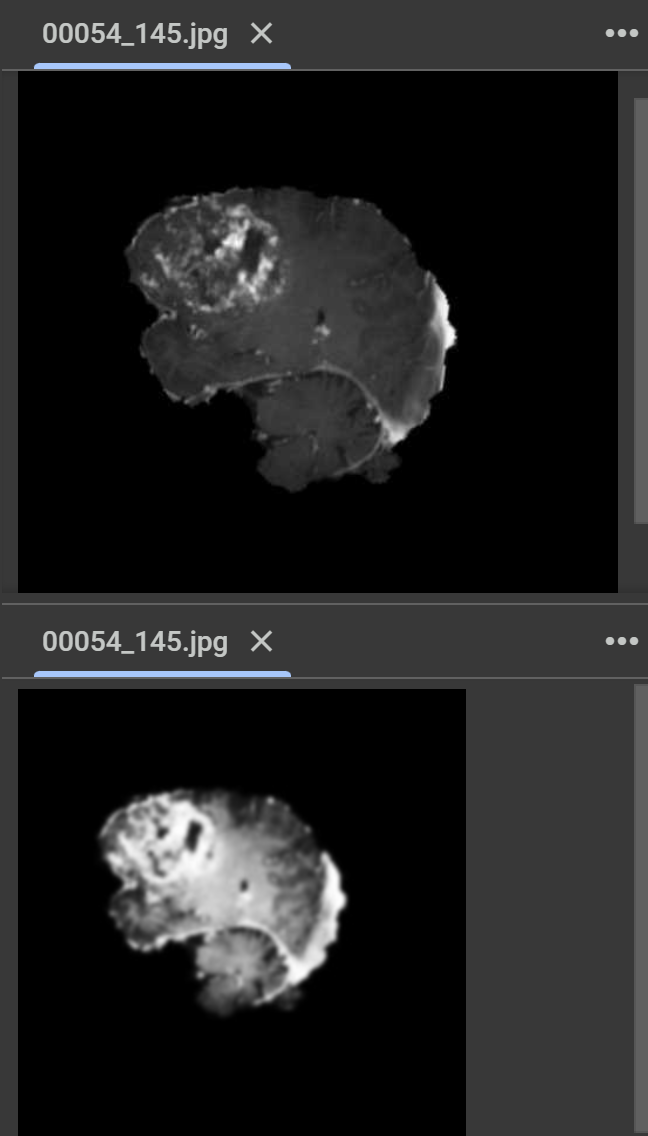

This is to test the modifications and visualizations on a single sample.

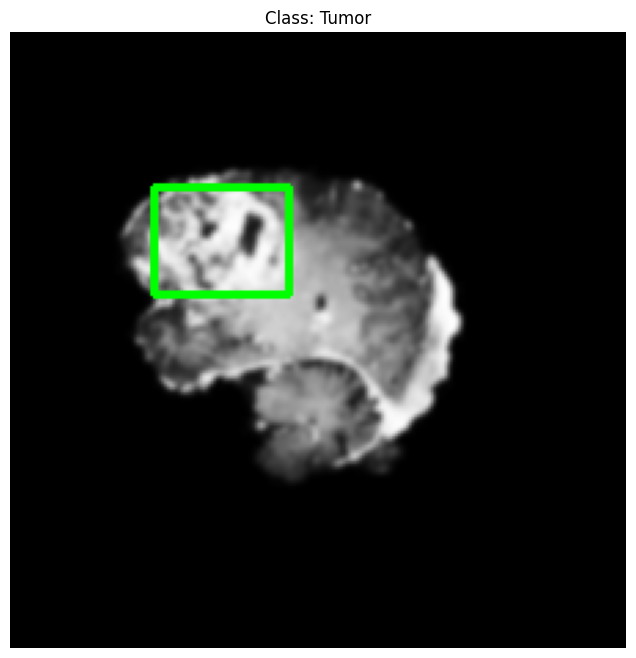

In [9]:
image_path = os.path.join(image_folder,image_files[0])
image = cv2.imread(image_path)
label = os.path.join(label_folder, label_files[0])
image = standardize_image(image)
image = enhance_image(image)
visualize_with_bounding_box(image, label)